In [1]:
import pandas as pd
from data import make_grid
import numpy as np
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.model_selection import cross_validate
from sklearn.metrics import auc, r2_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
data = make_grid("GB", 0.1)
print()
data.info()

Matching birds to grid cells: 

 98%|█████████▊| 98/100 [00:06<00:00, 15.13it/s]/Users/leoware/Documents/ns166_final_analysis/data/make_grid.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[spec] = counts
100%|██████████| 100/100 [00:06<00:00, 15.76it/s]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Columns: 106 entries, lat to Vanellus vanellus
dtypes: float64(6), int64(100)
memory usage: 2.7 MB


In [6]:
id_col = ['lat', 'lon']
cov_col = ['avg_temp', 'avg_min_month', 'avg_max_month']
target_col = list(set(data.columns) - set(id_col) - set(cov_col))

# Birds Dist

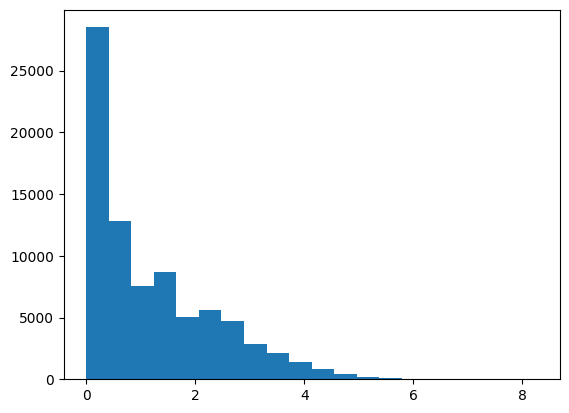

In [6]:
n_birds_per_grid = data[target_col].sum(axis=1)
n_each_per_grid = data[target_col].values.flatten()

plt.hist(np.log(n_each_per_grid[n_each_per_grid != 0]), bins=20)
plt.show()

# Sampling Model

In [7]:
bird = "Columba palumbus"
not_bird = list(set(target_col) - set([bird]))
not_bird_count = data[not_bird].sum(axis=1)

res = linregress(data[bird], not_bird_count)
res.rvalue**2

0.5702410319004594

Text(0.5, 0, 'Total sightings of other birds')

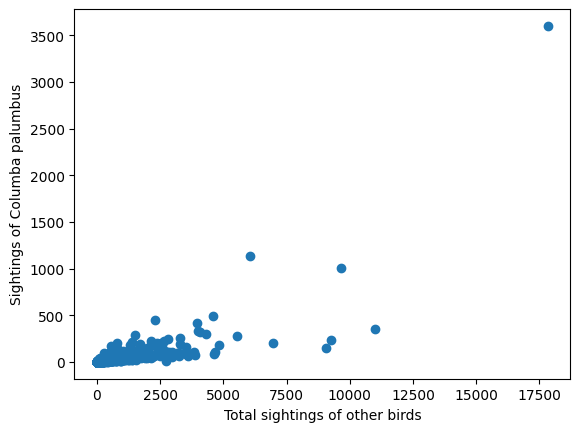

In [8]:
plt.scatter(not_bird_count, data[bird])
plt.ylabel(f"Sightings of {bird}")
plt.xlabel(f"Total sightings of other birds")

# Regression target

In [4]:
target_col

NameError: name 'target_col' is not defined

In [5]:
other_birds_r2 = []
cov_resid_r2 = []

for bird in target_col:
    not_bird = list(set(target_col) - set([bird]))
    not_bird_count = data[not_bird].sum(axis=1)

    model = LinearRegression()
    model.fit(not_bird_count.values.reshape(-1, 1), data[bird])
    y_hat = model.predict(not_bird_count.values.reshape(-1, 1))

    other_birds_r2.append(r2_score(data[bird], y_hat))

    resid = data[bird] - y_hat

    resid_model = LinearRegression()
    resid_model.fit(data[cov_col], resid)

    cov_resid_r2.append(r2_score(resid, resid_model.predict(data[cov_col])))

NameError: name 'target_col' is not defined

In [10]:
print("other birds", np.mean(other_birds_r2), np.quantile(other_birds_r2, 0.025), np.quantile(other_birds_r2, 0.975))

0.004693671260878829

In [11]:
pd.concat([resid, data[cov_col]], axis=1).corr()

,Columba palumbus,avg_temp,avg_min_month,avg_max_month
Columba palumbus,1.000000,-0.065719,-0.046885,-0.065676
avg_temp,-0.065719,1.000000,0.848108,0.896990
avg_min_month,-0.046885,0.848108,1.000000,0.528720
avg_max_month,-0.065676,0.896990,0.528720,1.000000


In [12]:
full_data = pd.concat([data[cov_col], not_bird_count], axis=1).values

full_model = LinearRegression()
full_model.fit(full_data, data[bird])
r2_score(data[bird], full_model.predict(full_data))

0.5723499420232321

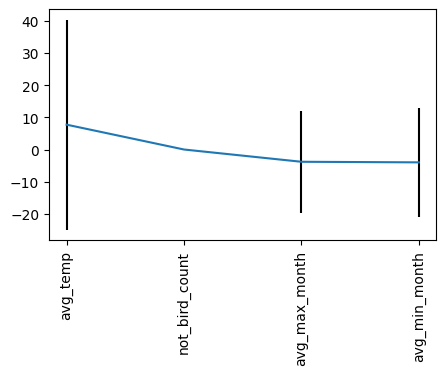

In [72]:
y = data[bird].values
X_from = pd.concat([data[cov_col], not_bird_count], axis=1).rename(columns={0: "not_bird_count"})
scores = []
coef = []

for _ in range(100):
    X = X_from.sample(X_from.shape[0], axis=0, replace=True)
    m = LinearRegression()
    m.fit(X, y)
    coef.append(m.coef_)
    scores.append(r2_score(y, m.predict(X)))

coef = np.vstack(coef)

cm = coef.mean(axis=0)
ord = np.argsort(cm)[::-1]

plt.figure(figsize=(5, 3))
plt.errorbar(np.array(X_from.columns)[ord], coef.mean(axis=0)[ord], yerr=coef.std(axis=0)[ord], ecolor="black")
plt.xticks(rotation=90)
plt.show()

# Binary Target

In [13]:
bird_present = (data[bird] > 0)

In [14]:
log_model = LogisticRegression()
log_model.fit(not_bird_count.values.reshape(-1, 1), data[bird] > 0)
log_model.score(not_bird_count.values.reshape(-1, 1), bird_present)
# confusion_matrix(log_model.predict(not_bird_count.values.reshape(-1, 1)), bird_present)

0.8919080322484324

In [15]:
big_log_model = LogisticRegression()
big_log_model.fit(full_data, bird_present)
big_log_model.score(full_data, bird_present)

0.8936996118244253

# Binary Target/Binary Data

In [16]:
X = (data[not_bird].values > 0).astype(int)
y = (data[bird].values > 0).astype(int)

bbModel = LogisticRegression()
bbModel.fit(X, y)
r2_score(y, bbModel.predict(X))

0.6833531947080735

In [17]:
X = np.hstack([data[cov_col], data[not_bird].values])
y = (data[bird].values > 0).astype(int)

X = StandardScaler().fit_transform(X)

full_bbModel = LogisticRegression()
full_bbModel.fit(X, y)
r2_score(y, full_bbModel.predict(X))

0.6248034080691891

# Certain Birds Matter?

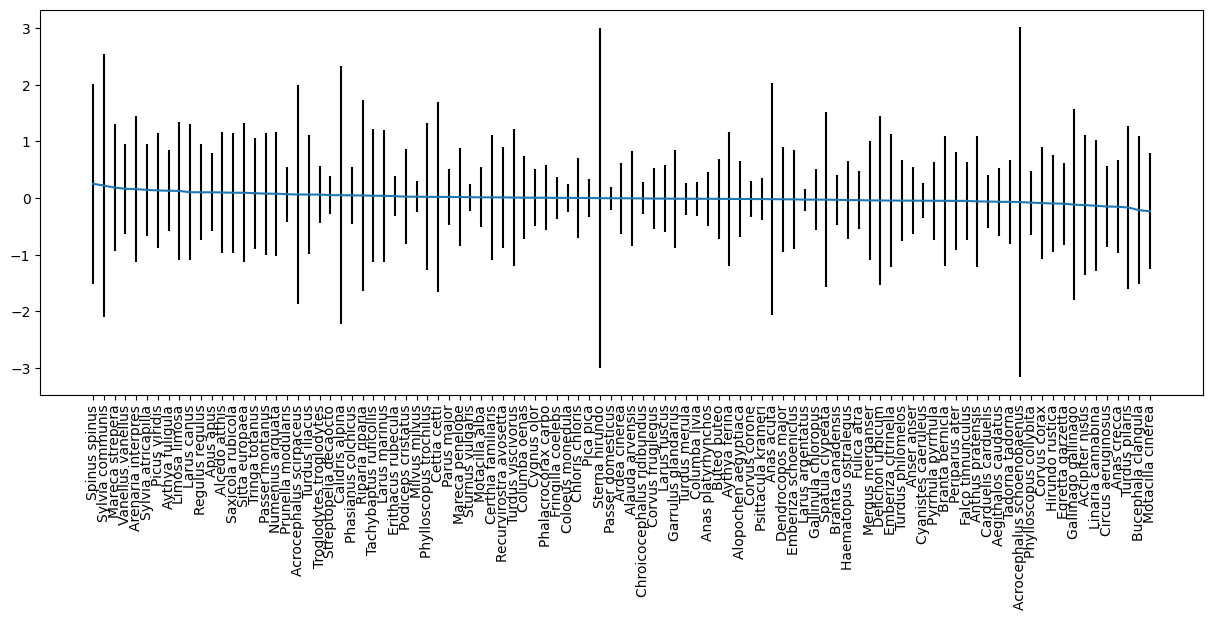

In [64]:
y = data[bird].values
scores = []
coef = []

for _ in range(100):
    X = data[not_bird].sample(data[not_bird].shape[0], axis=0, replace=True)
    m = LinearRegression()
    m.fit(X, y)
    coef.append(m.coef_)
    scores.append(r2_score(y, m.predict(X)))

coef = np.vstack(coef)

cm = coef.mean(axis=0)
ord = np.argsort(cm)[::-1]

plt.figure(figsize=(15, 5))
plt.errorbar(np.array(not_bird)[ord], coef.mean(axis=0)[ord], yerr=coef.std(axis=0)[ord], ecolor="black")
plt.xticks(rotation=90)
plt.show()

In [74]:
X = data[not_bird]
y = data[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.9923666072945742

In [73]:
X = data[not_bird + cov_col]
y = data[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.9923920507840565

# Can they predict residuals?

In [185]:
count = data[target_col].sum(axis=1).values.reshape(-1, 1)
birds_resid = data[target_col].values/count
birds_resid = pd.DataFrame(birds_resid, columns=target_col).fillna(0)
birds_resid[cov_col] = data[cov_col]
birds_resid["count"] = count/count.std()
birds_resid.head()

/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_32470/1863518968.py:2: RuntimeWarning: invalid value encountered in divide
  birds_resid = data[target_col].values/count


,Turdus merula,Gallinula chloropus,Tringa totanus,Podiceps cristatus,Apus apus,Anas acuta,Linaria cannabina,Spatula clypeata,Corvus corax,Alcedo atthis,...,Motacilla alba,Hirundo rustica,Alauda arvensis,Cettia cetti,Larus fuscus,Streptopelia decaocto,avg_temp,avg_min_month,avg_max_month,count
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,9.020824,3.736820,14.654806,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,8.999787,3.606866,14.741424,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,8.991556,3.606153,14.723858,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,8.968503,3.489750,14.792368,0.000000
4,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.0,0.0,0.0,0.0,0.142857,8.964840,3.707245,14.536806,0.009645


In [182]:
X = birds_resid[not_bird]
y = birds_resid[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.19966891765293926

In [183]:
X = birds_resid[not_bird + cov_col]
y = birds_resid[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.231102441769224

In [186]:
X = birds_resid[not_bird + cov_col + ["count"]]
y = birds_resid[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.23235814033934954

In [187]:
X = birds_resid[not_bird]
y = data[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.041056534575288905

In [188]:
X = birds_resid[not_bird + cov_col]
y = data[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.04606774522350365

In [189]:
X = birds_resid[not_bird + cov_col + ["count"]]
y = data[bird]
m = LinearRegression()
m.fit(X, y)
r2_score(y, m.predict(X))

0.6732534529303585

# Do individual birds relate to each other at all?

In [104]:
d = data[target_col]
resampled_corr = lambda(d): d.sample(data[target_col].shape[0], axis=0, replace=True).corr().values
shape = resampled_corr(d).shape
corr = np.vstack([resampled_corr(d).reshape((1,) + shape) for _ in tqdm(range(1000))])

100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


In [158]:
t = np.tril(corr).reshape(corr.shape[0], -1)
t = t[:, t.sum(axis=0) != 0]
t.shape

(1000, 5050)

In [159]:
cm = t.mean(axis=0)
cmp = np.percentile(t, 97.5, axis=0)
cmn = np.percentile(t, 2.5, axis=0)
sig_sign = (cmp > 0) == (cmn > 0)

print(f"n_boots={t.shape[0]}")
print(f"{sig_sign.sum()}/{sig_sign.size} significant correlations")

n_boots=1000
2959/5050 significant correlations


In [160]:
grid_counts = data[target_col].sum(axis=1).values.reshape(-1, 1)
d = (data[target_col] / grid_counts).dropna(axis=0)

resampled_corr = lambda d: d.sample(data[target_col].shape[0], axis=0, replace=True).corr().values
shape = resampled_corr(d).shape
corr = np.vstack([resampled_corr(d).reshape((1,) + shape) for _ in tqdm(range(1000))])

100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


In [164]:
t = np.tril(corr).reshape(corr.shape[0], -1)
t = t[:, t.sum(axis=0) != 0]
t.shape

(1000, 5050)

In [165]:
cm = t.mean(axis=0)
cmp = np.percentile(t, 97.5, axis=0)
cmn = np.percentile(t, 2.5, axis=0)
sig_sign = (cmp > 0) == (cmn > 0)

print(f"n_boots={t.shape[0]}")
print(f"{sig_sign.sum()}/{sig_sign.size} significant correlations")

n_boots=1000
2958/5050 significant correlations


In [166]:
pos = (t > 0).mean(axis=0)
neg = (t < 0).mean(axis=0)
ps = np.minimum(pos, neg)

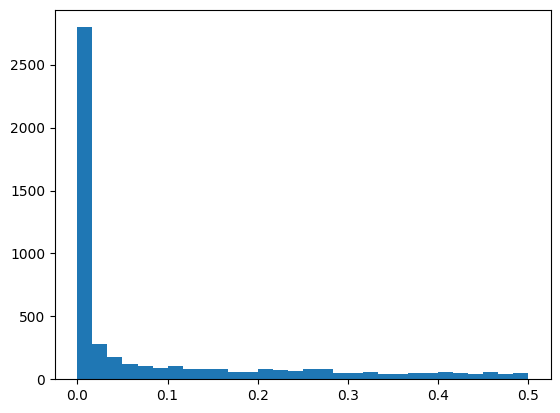

In [167]:
plt.hist(ps.flatten(), bins=30)
plt.show()

In [168]:
sig_count = (ps < 0.05).flatten().sum() / ps.size
alt_boots = (np.random.random(size=ps.shape + (1000,)) < 0.05).mean(axis=0).mean(axis=0)
(alt_boots > sig_count).mean()

0.0

Yes, they do

In [190]:
bird

'Columba palumbus'


Bearer WyI1NDk1MyIsIjhjNjNmNTY0YzM3ZjA4MTFjYzNjM2FkMTMzOTRiMmJjIl0.GFO4Yw.004G9ZcgnpyMqBM1QCs7mxJ-LYg